In [ ]:
# use plt to show one trajectory forces tracking
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_peg_hole_forces(h5_path):
    """
    从 H5 文件的 data_frames/demo_9 中读取 peg_hole_forces 数据，并绘制力曲线。
    
    参数:
        h5_path (str): .h5 文件的路径
    """
    # 检查文件是否存在
    if not os.path.exists(h5_path):
        print(f"❌ 文件不存在: {h5_path}")
        return

    try:
        with h5py.File(h5_path, 'r') as f:
            # 进入 data_frames 组
            if 'data_frames' not in f:
                print("❌ 根目录下没有 'data_frames' 组。")
                print("当前根组内容:", list(f.keys()))
                return

            data_group = f['data_frames']

            # 检查 demo_9 是否在 data_frames 下
            if 'demo_9' not in data_group:
                print("❌ 在 'data_frames' 中没有找到 'demo_9' 组。")
                print("data_frames 下的组:", list(data_group.keys()))
                return

            demo_group = data_group['demo_9']

            # 检查 peg_hole_forces 是否存在
            if 'peg_hole_forces' not in demo_group:
                print("❌ 在 'demo_9' 中没有找到 'peg_hole_forces' 数据集。")
                print("demo_9 中的数据集:", [k for k in demo_group.keys() if isinstance(demo_group[k], h5py.Dataset)])
                return

            # 读取 peg_hole_forces 数据
            forces = demo_group['peg_hole_forces'][:]  # shape: (183, 3)
            num_steps = forces.shape[0]
            time_steps = np.arange(num_steps)

            # 分离三个方向的力
            fx = forces[:, 0]  # X 方向
            fy = forces[:, 1]  # Y 方向
            fz = forces[:, 2]  # Z 方向

        # ==================== 绘图 ====================
        plt.style.use('seaborn-v0_8')  # 美观风格
        fig, ax = plt.subplots(figsize=(12, 6))

        # 使用专业配色
        colors = ['#D62728', '#1F77B4', '#2CA02C']  # 红、蓝、绿（经典清晰配色）

        ax.plot(time_steps, fx, label='X-axis (Fx)', color=colors[0], linewidth=2.5, alpha=0.9)
        ax.plot(time_steps, fy, label='Y-axis (Fy)', color=colors[1], linewidth=2.5, alpha=0.9)
        ax.plot(time_steps, fz, label='Z-axis (Fz)', color=colors[2], linewidth=2.5, alpha=0.9)

        # 标题和标签
        ax.set_title("peg_hole_forces with time", fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel("action_step (t)", fontsize=12)
        ax.set_ylabel("Contact Force (N)", fontsize=12)

        # 图例
        ax.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, shadow=True)

        # 网格
        ax.grid(True, linestyle='--', alpha=0.6, linewidth=0.8)

        # 布局优化
        plt.tight_layout()

        # 显示图像
        plt.show()

    except Exception as e:
        print(f"❌ 读取或绘制数据时发生错误: {e}")


# ============ 主程序 ============
if __name__ == "__main__":
    file_path = "/home/lvdousha/Downloads/isaac_sim_ws/wdy_data/h5file/SQUARE_PEG_IN_HOLE.h5"
    plot_peg_hole_forces(file_path)

In [ ]:
# use plt to show forces analise
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import re

def natural_sort_key(key):
    """Natural sort: demo_1, demo_2, ..., demo_10"""
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', key)]

def find_forces_dataset(group):
    """
    在 group 中查找包含 'forces' 的数据集（不区分大小写）
    返回第一个匹配的数据集名和数据
    """
    for key in group.keys():
        if 'forces' in key.lower() and isinstance(group[key], h5py.Dataset):
            return key, group[key][:]
    return None, None

def extract_task_name(filename):
    """从文件名提取任务名，如 SQUARE_PEG_IN_HOLE → 'Square Peg-in-Hole'"""
    basename = os.path.splitext(os.path.basename(filename))[0]
    # 替换下划线为空格，首字母大写，替换特定词
    name = basename.replace('_', ' ').title()
    name = name.replace('In', 'in').replace('Of', 'of')  # 小写介词
    return name

def load_all_force_data(h5_path, force_keyword='forces'):
    """
    通用加载器：从 data_frames/demo_* 中自动查找力数据集
    支持不同命名：peg_hole_forces, cube_forces, etc.
    """
    if not os.path.exists(h5_path):
        print(f"❌ File not found: {h5_path}")
        return None

    forces_list = []
    names_list = []
    dataset_name_hint = None  # 记录第一个找到的力数据集名，用于提示

    try:
        with h5py.File(h5_path, 'r') as f:
            if 'data_frames' not in f:
                print("❌ 'data_frames' group not found.")
                print("Available keys:", list(f.keys()))
                return None

            parent_group = f['data_frames']
            demo_names = [name for name in parent_group.keys() if name.startswith('demo_')]
            demo_names.sort(key=natural_sort_key)

            if not demo_names:
                print("❌ No demo_* groups found in data_frames.")
                return None

            print(f"🔍 Found {len(demo_names)} demos in '{h5_path}'")

            for name in demo_names:
                demo_group = parent_group[name]
                ds_name, data = find_forces_dataset(demo_group)

                if ds_name is None:
                    print(f"⚠️  No force dataset found in {name}")
                    continue

                if data.ndim != 2 or data.shape[1] != 3:
                    print(f"⚠️  Invalid shape {data.shape} for {ds_name} in {name}, skipped.")
                    continue

                forces_list.append(data)
                names_list.append(name)
                if dataset_name_hint is None:
                    dataset_name_hint = ds_name

        if not forces_list:
            print("❌ No valid force data loaded.")
            return None

        print(f"✅ Loaded {len(forces_list)} trajectories using dataset: '{dataset_name_hint}'")
        return forces_list, names_list, dataset_name_hint

    except Exception as e:
        print(f"❌ Error reading {h5_path}: {e}")
        return None

def plot_force_statistics(forces_list, names_list, dataset_name, task_name="Unknown Task"):
    """
    绘制力数据统计图（均值 ± 标准差）
    """
    if not forces_list:
        print("❌ No data to plot.")
        return

    lengths = [f.shape[0] for f in forces_list]
    max_len = max(lengths)
    min_len = min(lengths)

    print(f"📊 Length range: {min_len} ~ {max_len} steps")

    # Align using interpolation
    aligned = []
    for f in forces_list:
        old_t = np.linspace(0, 1, f.shape[0])
        new_t = np.linspace(0, 1, max_len)
        fx = np.interp(new_t, old_t, f[:, 0])
        fy = np.interp(new_t, old_t, f[:, 1])
        fz = np.interp(new_t, old_t, f[:, 2])
        aligned.append(np.c_[fx, fy, fz])
    aligned = np.array(aligned)
    t = np.arange(max_len)

    # Compute mean and std
    mean_forces = np.mean(aligned, axis=0)
    std_forces = np.std(aligned, axis=0)

    # Plot
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    fig.suptitle(f"Force Profiles - {task_name}\n(Data: '{dataset_name}', {len(forces_list)} trajectories)",
                 fontsize=16, fontweight='bold', y=0.98)

    colors = ['#D62728', '#1F77B4', '#2CA02C']
    labels = ['Fx (X-axis force)', 'Fy (Y-axis force)', 'Fz (Z-axis force)']

    for i, ax in enumerate(axes):
        ax.plot(t, mean_forces[:, i], color=colors[i], linewidth=2.5, label=f'{labels[i]} (mean)')
        ax.fill_between(t, mean_forces[:, i] - std_forces[:, i],
                        mean_forces[:, i] + std_forces[:, i],
                        color=colors[i], alpha=0.2, label=r'$\pm 1\sigma$')
        ax.set_ylabel("Force (N)")
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)

    axes[2].set_xlabel("Timestep (t)")
    axes[2].set_xlim(0, max_len - 1)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    print(f"\n📈 Summary for {task_name}:")
    for i, lbl in enumerate(['Fx', 'Fy', 'Fz']):
        peak = np.max(mean_forces[:, i])
        avg_std = np.mean(std_forces[:, i])
        print(f"  {lbl}: peak mean = {peak:.2f}N, avg std = {avg_std:.2f}N")

def plot_raw_trajectories(forces_list, names_list, task_name):
    """Plot raw trajectories without alignment"""
    plt.figure(figsize=(14, 6))
    colors = ['red', 'blue', 'green']
    labels = ['Fx', 'Fy', 'Fz']

    for forces in forces_list:
        t = np.arange(forces.shape[0])
        for i in range(3):
            plt.plot(t, forces[:, i], color=colors[i], alpha=0.5, linewidth=1.0)

    plt.title(f"Raw Force Trajectories - {task_name}", fontsize=14)
    plt.xlabel("Timestep (t)")
    plt.ylabel("Force (N)")
    plt.legend([plt.Line2D([0], [0], color=c, alpha=0.7) for c in colors], labels, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============ Main ============
if __name__ == "__main__":
    # ✅ 支持多个文件！只需添加到列表
    h5_files = [
        "/home/lvdousha/Downloads/isaac_sim_ws/wdy_data/h5file/SQUARE_PEG_IN_HOLE.h5"
    ]

    for file_path in h5_files:
        print(f"\n{'='*60}")
        print(f"📁 Processing: {file_path}")
        print(f"{'='*60}")

        result = load_all_force_data(file_path)
        if result is not None:
            forces_list, names_list, dataset_name = result
            task_name = extract_task_name(file_path)

            plot_raw_trajectories(forces_list, names_list, task_name)
            plot_force_statistics(forces_list, names_list, dataset_name, task_name)

✅ Loaded 61 valid trajectories (start_t=100)
💾 Saved: h5_analysis_results/DUAL_HOLE_PEG/DUAL_HOLE_IN_PEG_success_peg_hole_forces_stats_start100.png


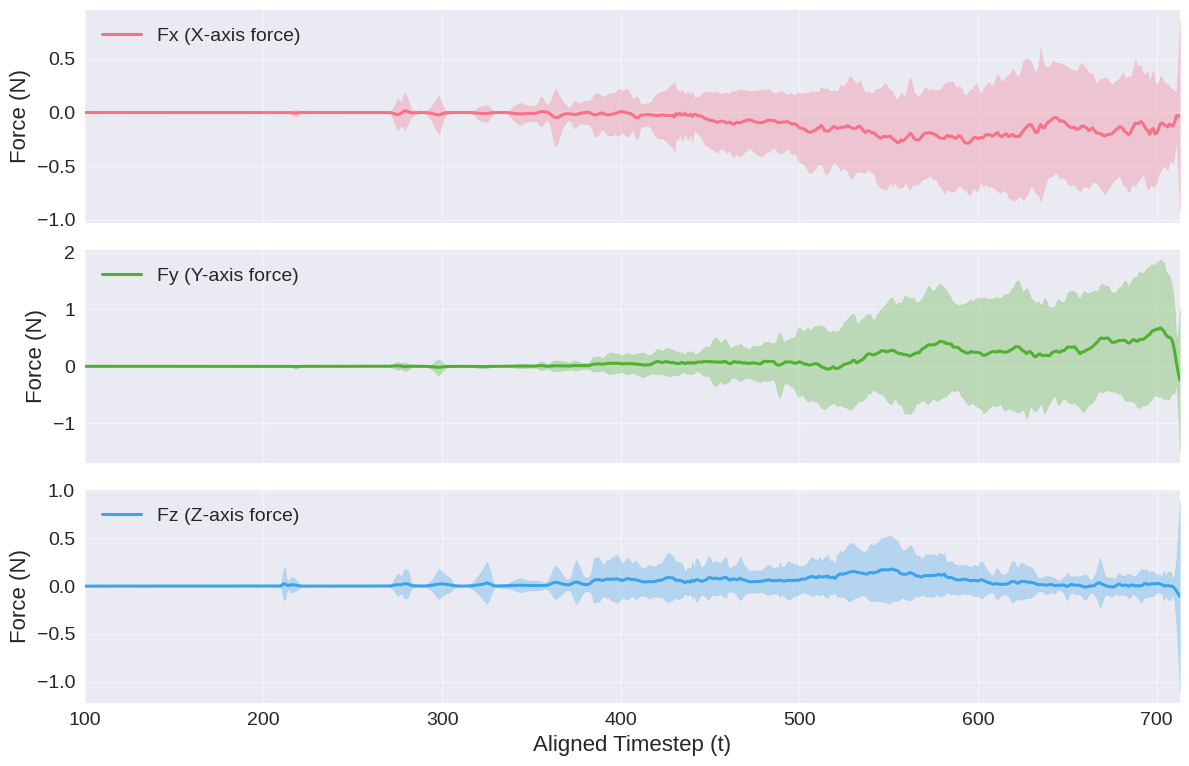

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import re

def natural_sort_key(key):
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', key)]

def load_all_peg_forces(h5_path, start_t=0, force_key=None):
    """
    从 data_frames/demo_* 中加载所有 contact forces 数据
    支持跳过前 start_t 步
    """
    if not os.path.exists(h5_path):
        print(f"❌ File not found: {h5_path}")
        return None

    forces_list = []
    names_list = []

    try:
        with h5py.File(h5_path, 'r') as f:
            if 'data_frames' not in f:
                print("❌ 'data_frames' group not found.")
                print("Root keys:", list(f.keys()))
                return None

            parent_group = f['data_frames']
            demo_names = [name for name in parent_group.keys() if name.startswith('demo_')]
            demo_names.sort(key=natural_sort_key)

            if not demo_names:
                print("❌ No demo_* groups found in data_frames.")
                return None

            # print(f"🔍 Found {len(demo_names)} demo trajectories: {demo_names}")

            for name in demo_names:
                group = parent_group[name]
                # 查找所有以 'forces' 结尾的数据集名称
                candidate_keys = [k for k in group.keys() if k.endswith('forces')]
                if not candidate_keys:
                    print(f"⚠️  {name}: No dataset ends with 'forces', skipped.")
                    continue

                # 如果指定了 force_key，优先使用
                if force_key is not None:
                    if force_key not in candidate_keys:
                        print(f"⚠️  {name}: '{force_key}' not found. Available: {candidate_keys}, skipped.")
                        continue
                    key_to_use = force_key
                else:
                    # 否则使用第一个匹配的
                    key_to_use = candidate_keys[0]
                    # print(f" {name}: Using auto-detected '{key_to_use}' from {candidate_keys}")
                
                data = group[key_to_use][:]
                if data.ndim != 2 or data.shape[1] != 3:
                    print(f"⚠️  {name} invalid shape {data.shape}, skipped.")
                    continue

                # 裁剪：从 start_t 开始
                if start_t >= data.shape[0]:
                    print(f"⚠️  {name}: start_t={start_t} >= length={data.shape[0]}, skipped.")
                    continue
                data = data[start_t:, :]  # 截取有效部分

                forces_list.append(data)
                names_list.append(name)

        print(f"✅ Loaded {len(forces_list)} valid trajectories (start_t={start_t})")
        return forces_list, names_list

    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

def align_forces_trajectories(forces_list, method='interpolate'):
    """
    对齐所有 forces 轨迹
    """
    lengths = [f.shape[0] for f in forces_list]
    if not lengths:
        return None
    max_len = max(lengths)
    aligned = []

    for forces in forces_list:
        T = forces.shape[0]
        if method == 'interpolate':
            old_t = np.linspace(0, 1, T)
            new_t = np.linspace(0, 1, max_len)
            fx = np.interp(new_t, old_t, forces[:, 0])
            fy = np.interp(new_t, old_t, forces[:, 1])
            fz = np.interp(new_t, old_t, forces[:, 2])
            aligned.append(np.c_[fx, fy, fz])
        else:
            min_len = min(lengths)
            aligned = [f[:min_len] for f in forces_list]

    return np.array(aligned), max_len


def plot_peg_forces_statistics(aligned_forces, max_len, task_name, output_dir, start_t=0):
    """
    绘制 forces 统计图（均值 ± 标准差），使用 seaborn 风格
    """
    if aligned_forces is None or aligned_forces.shape[0] == 0:
        print("❌ No data to plot.")
        return

    N, T, C = aligned_forces.shape  # C=3
    time_steps = np.arange(start_t, start_t + max_len)  # 调整 x 轴起点为 start_t

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # 使用 seaborn 风格和调色板
    plt.style.use('seaborn-v0_8')
    palette = sns.color_palette("husl", 3)  # Fx, Fy, Fz
    colors = [palette[0], palette[1], palette[2]]  # 红、绿、蓝风格
    labels = ['Fx (X-axis force)', 'Fy (Y-axis force)', 'Fz (Z-axis force)']

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    # fig.suptitle(f"Peg-Hole Contact Forces - {task_name}\n"
    #              f"Mean ± Std Deviation (N={N} demos, start_t={start_t})", 
    #              fontsize=14, fontweight='bold')

    for i, ax in enumerate(axes):
        mean_curve = np.mean(aligned_forces[:, :, i], axis=0)
        std_curve = np.std(aligned_forces[:, :, i], axis=0)

        ax.plot(time_steps, mean_curve, color=colors[i], linewidth=2.2, label=labels[i])
        ax.fill_between(time_steps, mean_curve - std_curve, mean_curve + std_curve,
                        color=colors[i], alpha=0.3)

        ax.set_ylabel("Force (N)", fontsize=16)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend(loc='upper left', fontsize=14)  # 将图例位置改为左上角
        ax.grid(True, alpha=0.4)

    axes[2].set_xlabel("Aligned Timestep (t)", fontsize=16)
    axes[2].tick_params(axis='x', labelsize=14)
    axes[2].set_xlim(start_t, start_t + max_len - 1)  # 调整 x 轴范围

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    png_path = output_dir / f"{task_name}_peg_hole_forces_stats_start{start_t}.png"
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {png_path}")
    plt.show()

# ============ 主程序 ============
if __name__ == "__main__":
    h5_path = "/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_data/00_successful/DUAL_HOLE_IN_PEG/h5_file/DUAL_HOLE_IN_PEG.h5"
    output_dir = "./h5_analysis_results/DUAL_HOLE_PEG"
    task_name = "DUAL_HOLE_IN_PEG_success"

    # 用户自定义：跳过前多少步
    start_t = 100

    # 1. 加载并裁剪 peg_hole_forces
    result = load_all_peg_forces(h5_path, start_t=start_t)
    if result is None:
        exit()

    forces_list, names_list = result

    # 2. 对齐轨迹
    aligned_forces, max_len = align_forces_trajectories(forces_list, method='interpolate')
    if aligned_forces is None:
        print("❌ No data after alignment.")
        exit()

    # 3. 绘图
    plot_peg_forces_statistics(aligned_forces, max_len, task_name, output_dir, start_t=start_t)


接下来的程序是处理机器人关节信息的

In [ ]:
# save one trajectory robot measured joint forces and torques to png and analisys to csv
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

def load_robot_joint_forces(h5_path, demo_name="demo_9"):
    """
    从 data_frames/demo_9 中加载 robot_measured_joint_forces
    返回: (T, 9, 6) 数组，维度含义: (时间步, 关节ID, [Fx,Fy,Fz,Mx,My,Mz])
    """
    if not os.path.exists(h5_path):
        print(f"❌ File not found: {h5_path}")
        return None

    try:
        with h5py.File(h5_path, 'r') as f:
            group_path = f"data_frames/{demo_name}"
            if group_path not in f:
                print(f"❌ Group '{group_path}' not found.")
                if 'data_frames' in f:
                    print("Available demos:", list(f['data_frames'].keys()))
                return None

            group = f[group_path]
            if 'robot_measured_joint_forces' not in group:
                print("❌ 'robot_measured_joint_forces' dataset not found.")
                return None

            data = group['robot_measured_joint_forces'][:]  # shape: (T, 54)
            T = data.shape[0]

            if data.shape[1] != 54:
                print(f"❌ Expected 54 dims, got {data.shape[1]}")
                return None

            # 重塑为 (T, 9, 6)
            forces_3d = data.reshape(T, 9, 6)  # 每6个为一个关节的 [F_x, F_y, F_z, M_x, M_y, M_z]
            print(f"✅ Loaded robot_measured_joint_forces: shape {forces_3d.shape} (T, Joints, Components)")
            return forces_3d

    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

def plot_joint_forces_by_joint(forces_3d, task_name, output_dir):
    """
    按关节绘制：每个关节的力和力矩变化
    """
    T, J, C = forces_3d.shape  # T: 时间步, J: 9关节, C: 6分量
    time_steps = np.arange(T)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # 分量标签
    components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
    force_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # 力：红、青、蓝
    torque_colors = ['#96CEB4', '#FFEAA7', '#DDA0DD']  # 力矩：绿、黄、紫

    plt.figure(figsize=(14, 10))
    for joint_id in range(J):
        ax = plt.subplot(3, 3, joint_id + 1)

        # 绘制力
        for i in range(3):
            plt.plot(time_steps, forces_3d[:, joint_id, i], 
                     label=components[i], color=force_colors[i], alpha=0.8, linewidth=1.5)
        # 绘制力矩
        for i in range(3, 6):
            plt.plot(time_steps, forces_3d[:, joint_id, i], 
                     label=components[i], color=torque_colors[i-3], alpha=0.8, linewidth=1.5)

        plt.title(f"Joint {joint_id}", fontweight='bold')
        plt.xlabel("Timestep (t)")
        plt.ylabel("Value")
        plt.grid(True, alpha=0.3)
        if joint_id == 0:
            plt.legend(fontsize=9, ncol=2)

    plt.suptitle(f"Robot Joint Forces & Torques - {task_name}\n(Each subplot: Joint-specific Fx,Fy,Fz,Mx,My,Mz)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    png_path = output_dir / f"{task_name}_joint_forces_by_joint.png"
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved per-joint plot: {png_path}")
    plt.show()

def plot_joint_forces_by_component(forces_3d, task_name, output_dir):
    """
    按分量绘制：所有关节的 Fx, Fy, ... 变化趋势
    """
    T, J, C = forces_3d.shape
    time_steps = np.arange(T)
    output_dir = Path(output_dir)

    components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    plt.figure(figsize=(16, 10))
    for i, comp in enumerate(components):
        ax = plt.subplot(2, 3, i + 1)
        for joint_id in range(J):
            plt.plot(time_steps, forces_3d[:, joint_id, i], 
                     color=colors[joint_id], alpha=0.6, linewidth=1.2, label=f"Joint {joint_id}" if i == 0 and joint_id < 3 else "")
        
        plt.title(f"Component: {comp}", fontweight='bold', color=colors[i])
        plt.xlabel("Timestep (t)")
        plt.ylabel("Force/Torque")
        plt.grid(True, alpha=0.3)

    plt.suptitle(f"Robot Joint Forces by Component - {task_name}", fontsize=16, fontweight='bold')
    plt.legend(loc='upper right', fontsize=8, ncol=2)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    png_path = output_dir / f"{task_name}_joint_forces_by_component.png"
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved by-component plot: {png_path}")
    plt.show()

def save_joint_forces_stats(forces_3d, task_name, output_dir):
    """
    保存统计信息到 CSV
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    records = []
    T, J, C = forces_3d.shape
    comp_names = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']

    for joint_id in range(J):
        for c in range(C):
            comp_data = forces_3d[:, joint_id, c]
            records.append({
                'Joint': f'joint_{joint_id}',
                'Component': comp_names[c],
                'Mean': np.mean(comp_data),
                'Std': np.std(comp_data),
                'Peak': np.max(np.abs(comp_data)),
                'Min': np.min(comp_data),
                'Max': np.max(comp_data),
                'Duration': T
            })

    df = pd.DataFrame(records)
    csv_path = output_dir / f"{task_name}_joint_forces_statistics.csv"
    df.to_csv(csv_path, index=False)
    print(f"📊 Saved statistics to: {csv_path}")

# ============ 主程序 ============
if __name__ == "__main__":
    h5_path = "/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_data/h5file/SQUARE_PEG_IN_HOLE.h5"
    output_dir = "./h5_analysis_results"
    task_name = "Square_Peg_In_Hole"

    # 加载数据
    forces_3d = load_robot_joint_forces(h5_path, demo_name="demo_9")
    if forces_3d is not None:
        # 绘图
        plot_joint_forces_by_joint(forces_3d, task_name, output_dir)
        plot_joint_forces_by_component(forces_3d, task_name, output_dir)
        # 保存统计
        save_joint_forces_stats(forces_3d, task_name, output_dir)

In [ ]:
# save all robot joint forces data in one png(3*3)
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from pathlib import Path

def natural_sort_key(key):
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', key)]

def load_all_robot_joint_forces(h5_path):
    """
    从 data_frames/demo_* 中加载所有 robot_measured_joint_forces
    返回: 列表，每个元素是 (T, 9, 6) 的 numpy 数组
    """
    if not os.path.exists(h5_path):
        print(f"❌ File not found: {h5_path}")
        return None

    forces_list = []  # 存储每个 demo 的 (T, 9, 6)
    names_list = []

    try:
        with h5py.File(h5_path, 'r') as f:
            if 'data_frames' not in f:
                print("❌ 'data_frames' group not found.")
                return None

            parent_group = f['data_frames']
            demo_names = [name for name in parent_group.keys() if name.startswith('demo_')]
            demo_names.sort(key=natural_sort_key)

            if not demo_names:
                print("❌ No demo_* groups found.")
                return None

            print(f"🔍 Found {len(demo_names)} demos.")

            for name in demo_names:
                group = parent_group[name]
                if 'robot_measured_joint_forces' not in group:
                    print(f"⚠️  {name}: Missing 'robot_measured_joint_forces', skipped.")
                    continue

                data = group['robot_measured_joint_forces'][:]  # (T, 54)
                if data.ndim != 2 or data.shape[1] != 54:
                    print(f"⚠️  {name}: Invalid shape {data.shape}, skipped.")
                    continue

                # 重塑为 (T, 9, 6)
                try:
                    forces_3d = data.reshape(data.shape[0], 9, 6)
                    forces_list.append(forces_3d)
                    names_list.append(name)
                except Exception as e:
                    print(f"⚠️  {name}: Reshape failed: {e}")
                    continue

        if not forces_list:
            print("❌ No valid robot joint forces data loaded.")
            return None

        print(f"✅ Loaded {len(forces_list)} trajectories with robot_measured_joint_forces.")
        return forces_list, names_list

    except Exception as e:
        print(f"❌ Error reading {h5_path}: {e}")
        return None

def align_trajectories_3d(forces_list, method='interpolate'):
    """
    对齐所有 (T, 9, 6) 轨迹
    返回: (N, T_max, 9, 6) 的数组
    """
    lengths = [f.shape[0] for f in forces_list]
    max_len = max(lengths)
    aligned = []

    print(f"📊 Aligning trajectories to {max_len} steps using '{method}'...")

    for forces in forces_list:
        T, J, C = forces.shape  # T: time, J=9, C=6
        if method == 'interpolate':
            old_t = np.linspace(0, 1, T)
            new_t = np.linspace(0, 1, max_len)
            aligned_joint = np.zeros((max_len, J, C))
            for j in range(J):
                for c in range(C):
                    aligned_joint[:, j, c] = np.interp(new_t, old_t, forces[:, j, c])
            aligned.append(aligned_joint)
        else:
            print("⚠️  Only 'interpolate' supported for now.")
            return None

    return np.array(aligned)  # shape: (N, T_max, 9, 6)

import matplotlib.pyplot as plt
import seaborn as sns  # 导入 seaborn，用于更好的配色方案
from pathlib import Path

def plot_robot_forces_mean_std(aligned_4d, task_name, output_dir):
    """
    绘制每关节的力和力矩的均值 ± 标准差
    aligned_4d: (N, T, 9, 6)
    """
    N, T_max, J, C = aligned_4d.shape
    time_steps = np.arange(T_max)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
    
    # 使用 seaborn 的调色板，确保颜色美观且可区分
    palette = sns.color_palette("husl", C)  # 饱和度适中的柔和色调
    comp_colors = palette

    # 定义线型和标记符，增强黑白打印兼容性
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'v']

    plt.figure(figsize=(16, 12))
    for joint_id in range(J):
        ax = plt.subplot(3, 3, joint_id + 1)

        for c in range(C):
            mean_curve = np.mean(aligned_4d[:, :, joint_id, c], axis=0)
            std_curve = np.std(aligned_4d[:, :, joint_id, c], axis=0)

            # 结合颜色、线型和标记符
            linestyle = line_styles[c % len(line_styles)]
            marker = markers[c % len(markers)]

            ax.plot(time_steps, mean_curve, 
                    label=components[c], 
                    color=comp_colors[c], 
                    linestyle=linestyle, 
                    marker=marker, 
                    markevery=50,  # 每 50 步标记一次
                    linewidth=1.5)

            # 使用低透明度的阴影区域
            ax.fill_between(time_steps, 
                           mean_curve - std_curve, 
                           mean_curve + std_curve,
                           color=comp_colors[c], 
                           alpha=0.2)

        # 添加图例
        ax.legend(fontsize=9, ncol=2, loc='upper right')

        # 设置标题和坐标轴标签
        ax.set_title(f"Joint {joint_id} - Mean ± Std", fontweight='bold')
        ax.set_xlabel("Timestep (t)")
        ax.set_ylabel("Force/Torque")
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"Robot Joint Forces Across All Demos - {task_name}\n(Mean ± Std Deviation, N={N})", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    png_path = output_dir / f"{task_name}_robot_forces_mean_std.png"
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved mean±std plot: {png_path}")
    plt.show()
    
    
def save_robot_forces_summary_csv(aligned_4d, task_name, output_dir):
    """
    保存每关节每分量的统计摘要
    """
    N, T, J, C = aligned_4d.shape
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    records = []
    components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']

    for joint_id in range(J):
        for c in range(C):
            data = aligned_4d[:, :, joint_id, c]  # (N, T)
            mean_over_time = np.mean(data, axis=1)  # 每条轨迹的平均值
            peak_over_time = np.max(np.abs(data), axis=1)

            records.append({
                'Joint': f'joint_{joint_id}',
                'Component': components[c],
                'Avg_Mean': np.mean(mean_over_time),
                'Std_Mean': np.std(mean_over_time),
                'Avg_Peak': np.mean(peak_over_time),
                'Std_Peak': np.std(peak_over_time),
                'Total_Trials': N
            })

    df = pd.DataFrame(records)
    csv_path = output_dir / f"{task_name}_robot_forces_summary.csv"
    df.to_csv(csv_path, index=False)
    print(f"📊 Saved summary stats: {csv_path}")

# ============ 主程序 ============
if __name__ == "__main__":
    h5_path = "/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_data/h5file/SQUARE_PEG_IN_HOLE.h5"
    output_dir = "./h5_analysis_results"
    task_name = "Square_Peg_In_Hole"

    # 加载所有 demo 的 robot_measured_joint_forces
    result = load_all_robot_joint_forces(h5_path)
    if result is not None:
        forces_list, names_list = result

        # 对齐所有轨迹
        aligned_4d = align_trajectories_3d(forces_list, method='interpolate')
        if aligned_4d is None:
            exit()

        # 绘图：每关节均值 ± 标准差
        plot_robot_forces_mean_std(aligned_4d, task_name, output_dir)

        # 保存统计摘要
        save_robot_forces_summary_csv(aligned_4d, task_name, output_dir)

🔍 Found 27 demos.
✅ Loaded 27 trajectories with robot_measured_joint_forces.
📊 Aligning trajectories to 521 steps using 'interpolate'...
💾 Saved torque-only plot: h5_analysis_results/DUAL_HOLE_PEG/DUAL_HOLE_IN_PEG_success_torques_2X4_robot_torques_mean_std.png


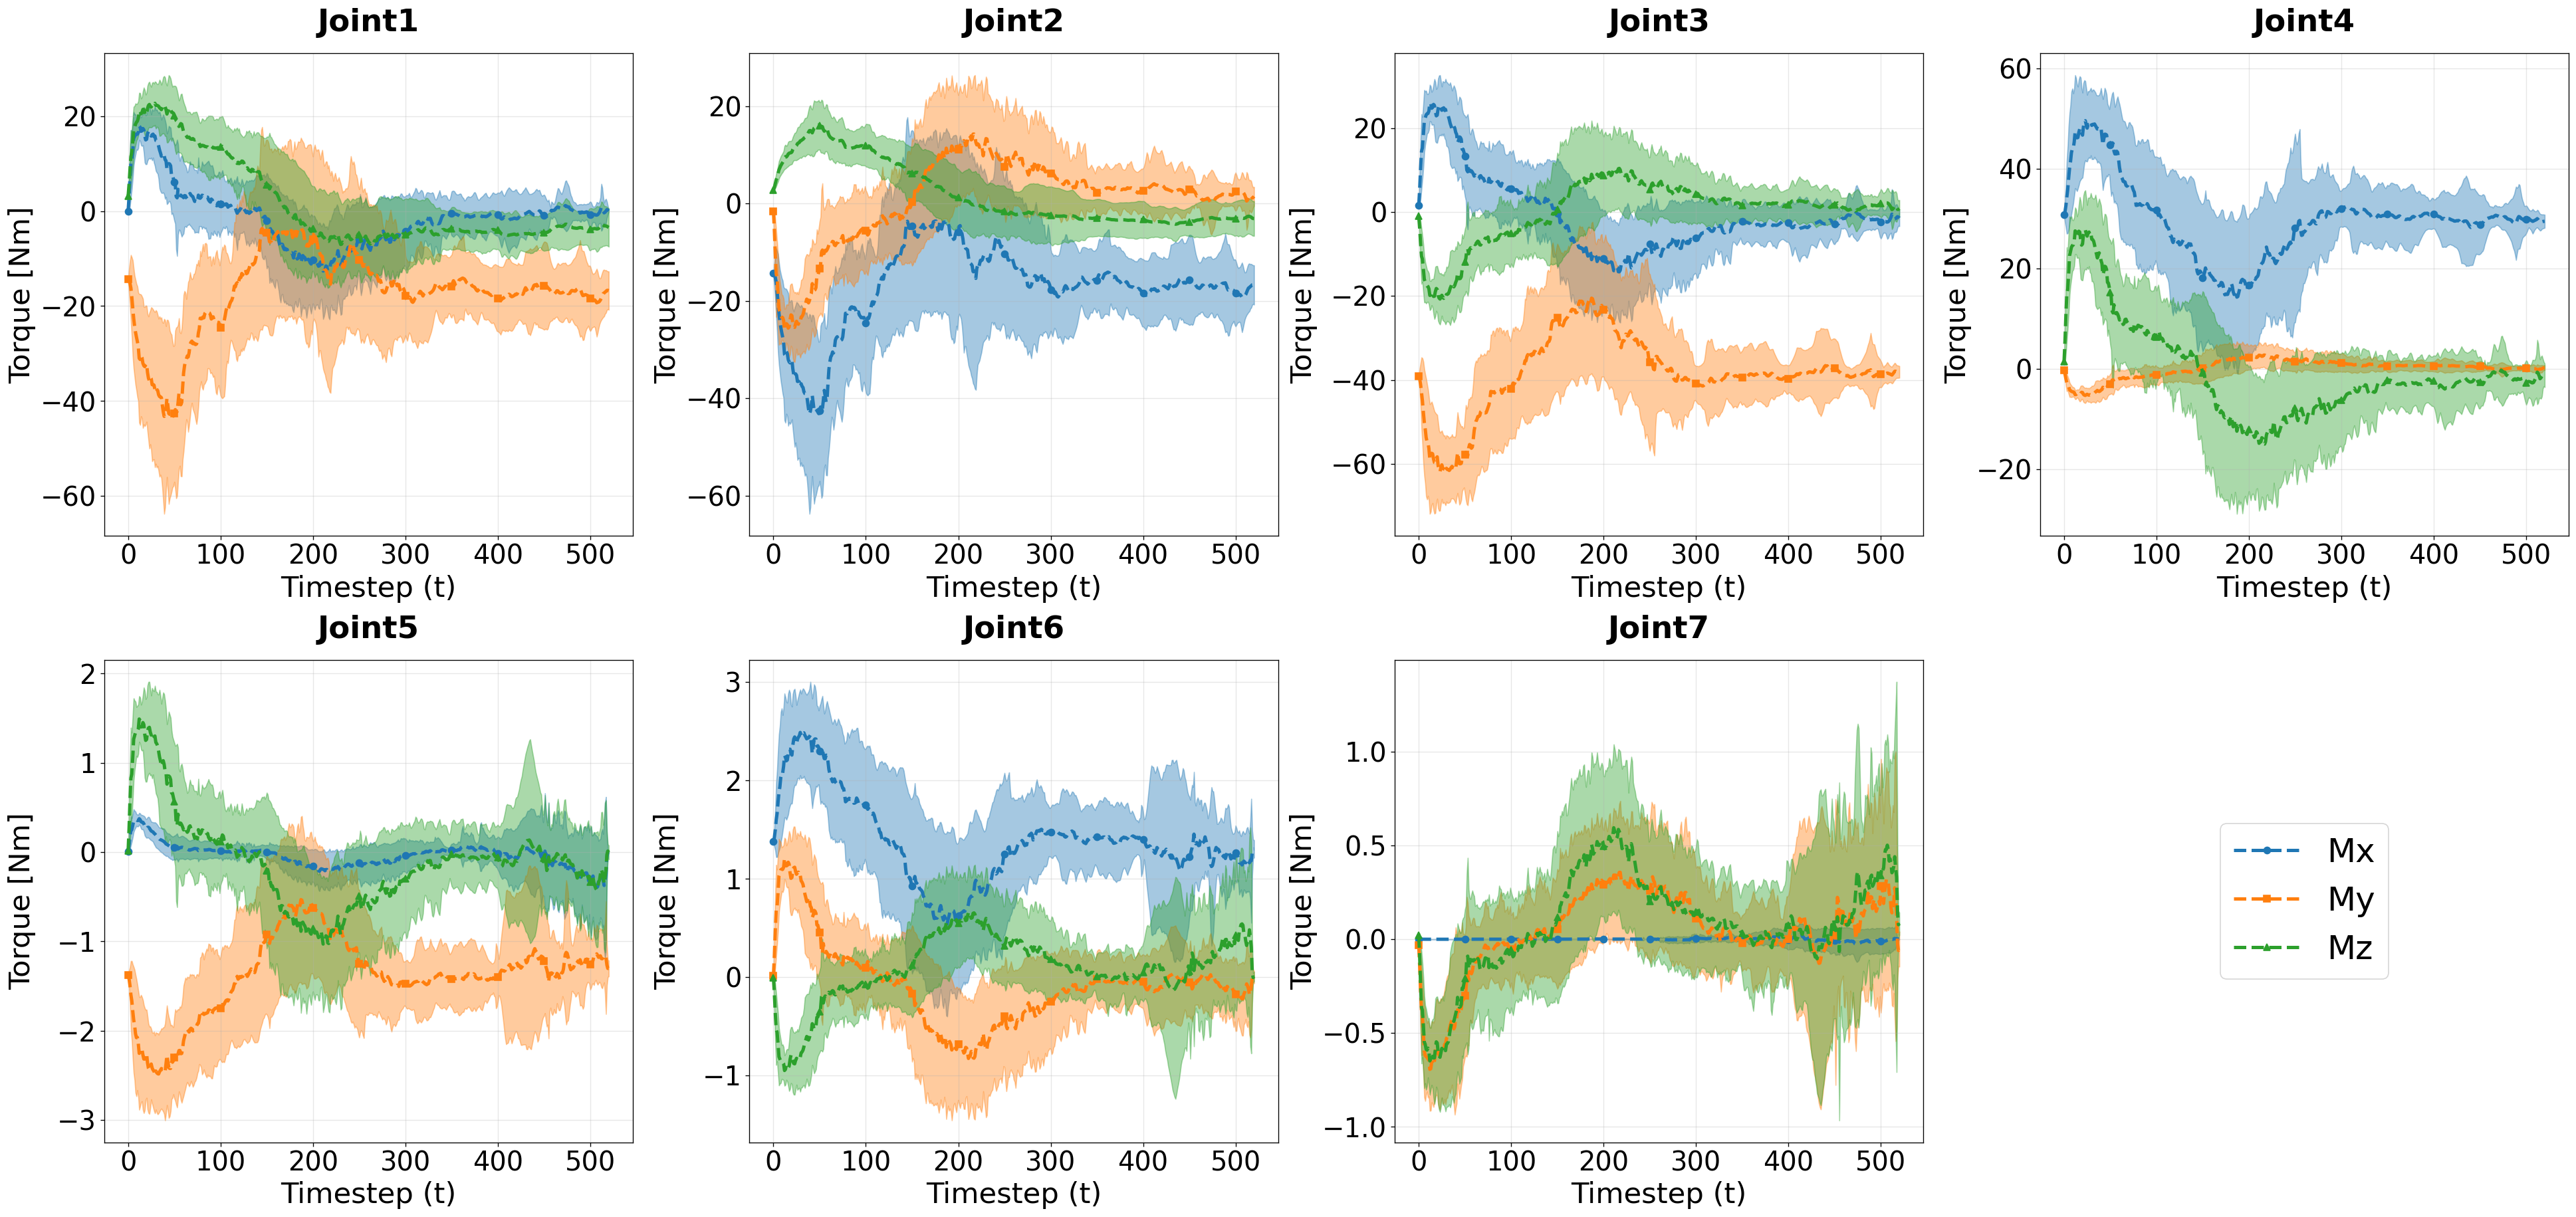

📊 Saved summary stats: h5_analysis_results/DUAL_HOLE_PEG/DUAL_HOLE_IN_PEG_success_torques_2X4_robot_forces_summary.csv


In [16]:
# save all robot joint forces data in one png(2*5)
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import seaborn as sns
from pathlib import Path

def natural_sort_key(key):
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', key)]

def load_all_robot_joint_forces(h5_path):
    """
    从 data_frames/demo_* 中加载所有 robot_measured_joint_forces
    返回: 列表，每个元素是 (T, 9, 6) 的 numpy 数组
    """
    if not os.path.exists(h5_path):
        print(f"❌ File not found: {h5_path}")
        return None

    forces_list = []  # 存储每个 demo 的 (T, 9, 6)
    names_list = []

    try:
        with h5py.File(h5_path, 'r') as f:
            if 'data_frames' not in f:
                print("❌ 'data_frames' group not found.")
                return None

            parent_group = f['data_frames']
            demo_names = [name for name in parent_group.keys() if name.startswith('demo_')]
            demo_names.sort(key=natural_sort_key)

            if not demo_names:
                print("❌ No demo_* groups found.")
                return None

            print(f"🔍 Found {len(demo_names)} demos.")

            for name in demo_names:
                group = parent_group[name]
                if 'robot_measured_joint_forces' not in group:
                    print(f"⚠️  {name}: Missing 'robot_measured_joint_forces', skipped.")
                    continue

                data = group['robot_measured_joint_forces'][:]  # (T, 54)
                if data.ndim != 2 or data.shape[1] != 54:
                    print(f"⚠️  {name}: Invalid shape {data.shape}, skipped.")
                    continue

                # 重塑为 (T, 9, 6)
                try:
                    forces_3d = data.reshape(data.shape[0], 9, 6)
                    forces_list.append(forces_3d)
                    names_list.append(name)
                except Exception as e:
                    print(f"⚠️  {name}: Reshape failed: {e}")
                    continue

        if not forces_list:
            print("❌ No valid robot joint forces data loaded.")
            return None

        print(f"✅ Loaded {len(forces_list)} trajectories with robot_measured_joint_forces.")
        return forces_list, names_list

    except Exception as e:
        print(f"❌ Error reading {h5_path}: {e}")
        return None

def align_trajectories_3d(forces_list, method='interpolate'):
    """
    对齐所有 (T, 9, 6) 轨迹
    返回: (N, T_max, 9, 6) 的数组
    """
    lengths = [f.shape[0] for f in forces_list]
    max_len = max(lengths) 
    aligned = []

    print(f"📊 Aligning trajectories to {max_len} steps using '{method}'...")

    for forces in forces_list:
        T, J, C = forces.shape  # T: time, J=9, C=6
        if method == 'interpolate':
            old_t = np.linspace(0, 1, T)
            new_t = np.linspace(0, 1, max_len)
            aligned_joint = np.zeros((max_len, J, C))
            for j in range(J):
                for c in range(C):
                    aligned_joint[:, j, c] = np.interp(new_t, old_t, forces[:, j, c])
            aligned.append(aligned_joint)
        else:
            print("⚠️  Only 'interpolate' supported for now.")
            return None

    return np.array(aligned)  # shape: (N, T_max, 9, 6)

# original version of plot_robot_forces_mean_std, torques and forces are in one side axis
# def plot_robot_forces_mean_std(aligned_4d, task_name, output_dir):
#     """
#     绘制每关节的力和力矩的均值 ± 标准差
#     aligned_4d: (N, T, 9, 6)
#     """
#     N, T_max, J, C = aligned_4d.shape
#     time_steps = np.arange(T_max)
#     output_dir = Path(output_dir)
#     output_dir.mkdir(exist_ok=True)

#     components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
#     joint_names = [
#         'panda_joint1', 'panda_joint2', 'panda_joint3', 
#         'panda_joint4', 'panda_joint5', 'panda_joint6', 
#         'panda_joint7', 'panda_finger_joint1', 'panda_finger_joint2'
#     ]

#     # seaborn 调色板
#     palette = sns.color_palette("husl", C)
#     comp_colors = palette

#     line_styles = ['-', '--', '-.', ':']
#     markers = ['o', 's', '^', 'v']

#     fig, axes = plt.subplots(2, 5, figsize=(30, 14), dpi=120)
#     axes = axes.flatten()

#     for joint_id in range(J):
#         ax = axes[joint_id]
#         for c in range(C):
#             mean_curve = np.mean(aligned_4d[:, :, joint_id, c], axis=0)
#             std_curve = np.std(aligned_4d[:, :, joint_id, c], axis=0)

#             linestyle = line_styles[c % len(line_styles)]
#             marker = markers[c % len(markers)]

#             ax.plot(time_steps, mean_curve,
#                     label=components[c],
#                     color=comp_colors[c],
#                     linestyle=linestyle,
#                     marker=marker,
#                     markevery=50,
#                     linewidth=2.2)

#             ax.fill_between(time_steps,
#                             mean_curve - std_curve,
#                             mean_curve + std_curve,
#                             color=comp_colors[c],
#                             alpha=0.2)

#         # ✅ 设置标题和标签
#         ax.set_title(joint_names[joint_id], fontsize=20, fontweight='bold', pad=20)
#         ax.set_xlabel("Timestep (t)", fontsize=18)

#         # ✅ 区分力和力矩的单位
#         if any(comp in ['Fx', 'Fy', 'Fz'] for comp in components):
#             ylabel = "Force [N] & Torque [Nm]"
#         else:
#             ylabel = "Force/Torque"
#         ax.set_ylabel(ylabel, fontsize=18)

#         ax.grid(True, alpha=0.3)
#         ax.tick_params(axis='both', which='major', labelsize=15)

#     # ✅ 最后一个子图专门放图例
#     legend_ax = axes[-1]
#     legend_ax.axis('off')
#     handles, labels = axes[0].get_legend_handles_labels()
#     legend_ax.legend(handles, labels, fontsize=16, ncol=3, loc='center')

#     # ✅ 自动调整布局，避免重叠
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.subplots_adjust(wspace=0.3, hspace=0.4)

#     # 保存
#     png_path = output_dir / f"{task_name}_robot_forces_mean_std.png"
#     plt.savefig(png_path, dpi=300, bbox_inches='tight')
#     print(f"💾 Saved mean±std plot: {png_path}")
#     plt.show()

# this version is for dual-axis plot of force and torque
# def plot_robot_forces_mean_std(aligned_4d, task_name, output_dir):
#     N, T_max, J, C = aligned_4d.shape
#     time_steps = np.arange(T_max)
#     output_dir = Path(output_dir)
#     output_dir.mkdir(exist_ok=True)

#     components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
#     joint_names = [
#         'Joint1', 'Joint2', 'Joint3',
#         'Joint4', 'Joint5', 'Joint6',
#         'Joint7', 'Finger_joint1', 'Finger_joint2'
#     ]

#     # force_colors = sns.color_palette("Set1", 3)   # Fx, Fy, Fz
#     # torque_colors = sns.color_palette("Dark2", 3) # Mx, My, Mz
#     # comp_colors = force_colors + torque_colors
#     # 6 种高区分度颜色
#     comp_colors = sns.color_palette("tab10", 6)
#     line_styles = ['-', '--', '-.', ':']
#     # markers = ['o', 's', '^', 'v']
#     # 6 种不同的标记符号
#     markers = ["o", "s", "^", "D", "v", "P"]

#     fig, axes = plt.subplots(2, 5, figsize=(34, 14), dpi=120)
#     axes = axes.flatten()

#     # 用于收集 legend 的第一个关节轴
#     first_ax_force, first_ax_torque = None, None

#     for joint_id in range(J):
#         ax_force = axes[joint_id]
#         ax_torque = ax_force.twinx()

#         if joint_id == 0:  # 保存第一个关节的两个轴
#             first_ax_force, first_ax_torque = ax_force, ax_torque

#         # # 6 种高区分度颜色
#         # comp_colors = sns.color_palette("tab10", 6)

#         # # 6 种不同的标记符号
#         # markers = ["o", "s", "^", "D", "v", "P"]

#         for c in range(C):
#             mean_curve = np.mean(aligned_4d[:, :, joint_id, c], axis=0)
#             std_curve = np.std(aligned_4d[:, :, joint_id, c], axis=0)

#             marker = markers[c]
#             color = comp_colors[c]

#             if c < 3:  # 力
#                 # ax_force.plot(time_steps, mean_curve,
#                 #             label=components[c],
#                 #             color=color,
#                 #             linestyle="-",
#                 #             marker=marker,
#                 #             markevery=50,
#                 #             linewidth=2.0)
#                 # ax_force.fill_between(time_steps,
#                 #                     mean_curve - std_curve,
#                 #                     mean_curve + std_curve,
#                 #                     color=color,
#                 #                     alpha=0.2)
#                 pass
#             else:      # 力矩
#                 ax_torque.plot(time_steps, mean_curve,
#                             label=components[c],
#                             color=color,
#                             linestyle="--",
#                             marker=marker,
#                             markevery=50,
#                             linewidth=2.0)
#                 ax_torque.fill_between(time_steps,
#                                     mean_curve - std_curve,
#                                     mean_curve + std_curve,
#                                     color=color,
#                                     alpha=0.2)


#         ax_force.set_title(joint_names[joint_id],
#                            fontsize=24, fontweight='bold', pad=20)
#         ax_force.set_xlabel("Timestep (t)", fontsize=22)
#         # ax_force.set_ylabel("Force [N]", fontsize=22)
#         ax_torque.set_ylabel("Torque [Nm]", fontsize=22)

#         ax_force.tick_params(axis='both', labelsize=20)
#         ax_torque.tick_params(axis='y', labelsize=20)

#         ax_force.grid(True, alpha=0.3)

#     # ✅ 图例放在最后一个子图
#     legend_ax = axes[-1]
#     legend_ax.axis('off')

#     # 从第一个关节的两个轴收集 legend
#     h1, l1 = first_ax_force.get_legend_handles_labels()
#     h2, l2 = first_ax_torque.get_legend_handles_labels()
#     all_handles, all_labels = h1 + h2, l1 + l2

#     legend_ax.legend(all_handles, all_labels,
#                      fontsize=24, ncol=2, loc='center')

#     plt.tight_layout(rect=[0.05, 0, 0.95, 0.96])
#     fig.align_ylabels()

#     png_path = output_dir / f"{task_name}_robot_forces_mean_std_dual_axis.png"
#     plt.savefig(png_path, dpi=300, bbox_inches='tight')
#     print(f"💾 Saved dual-axis plot: {png_path}")
#     plt.show()

# this version is for torque-only or force-only plot
# def plot_robot_forces_mean_std(aligned_4d, task_name, output_dir):
#     N, T_max, J, C = aligned_4d.shape
#     time_steps = np.arange(T_max)
#     output_dir = Path(output_dir)
#     output_dir.mkdir(exist_ok=True)

#     components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
#     joint_names = [
#         'Joint1', 'Joint2', 'Joint3',
#         'Joint4', 'Joint5', 'Joint6',
#         'Joint7', 'Finger_joint1', 'Finger_joint2'
#     ]

#     # 只关注力矩：Mx, My, Mz → 对应索引 3, 4, 5
#     torque_indices = [3, 4, 5]
#     torque_components = ['Mx', 'My', 'Mz']

#     # 只关注：Fx, Fy, Fz → 对应索引 0, 1, 2
#     force_indices = [0, 1, 2]
#     force_components = ['Fx', 'Fy', 'Fz']

#     # 为力矩分配颜色和标记
#     comp_colors = sns.color_palette("tab10", 3)  # 只需要3种颜色
#     markers = ["o", "s", "^"]  # 只需要3种标记

#     fig, axes = plt.subplots(2, 5, figsize=(34, 14), dpi=120)
#     axes = axes.flatten()

#     # 用于收集 legend 的第一个关节轴（现在只用一个轴）
#     first_ax_torque = None

#     for joint_id in range(J):
#         ax = axes[joint_id]  # 主轴，我们只用它画扭矩

#         if joint_id == 0:
#             first_ax_torque = ax

#         for i, c in enumerate(force_indices):
#             mean_curve = np.mean(aligned_4d[:, :, joint_id, c], axis=0)
#             std_curve = np.std(aligned_4d[:, :, joint_id, c], axis=0)

#             marker = markers[i]
#             color = comp_colors[i]

#             # 绘制扭矩曲线 + 填充标准差区域
#             ax.plot(time_steps, mean_curve,
#                     label=force_components[i],
#                     color=color,
#                     linestyle="--",
#                     marker=marker,
#                     markevery=50,
#                     linewidth=3.0)
#             ax.fill_between(time_steps,
#                             mean_curve - std_curve,
#                             mean_curve + std_curve,
#                             color=color,
#                             alpha=0.4)

#         ax.set_title(joint_names[joint_id],
#                      fontsize=28, fontweight='bold', pad=20)
#         ax.set_xlabel("Timestep (t)", fontsize=26)
#         ax.set_ylabel("Force [N]", fontsize=26)  # 只保留扭矩Y轴

#         ax.tick_params(axis='both', labelsize=24)
#         ax.grid(True, alpha=0.3)

#     # ✅ 图例放在最后一个子图
#     legend_ax = axes[-1]
#     legend_ax.axis('off')

#     # 从第一个关节轴收集 legend
#     h, l = first_ax_torque.get_legend_handles_labels()
#     legend_ax.legend(h, l,
#                      fontsize=30, ncol=1, loc='center')  # 3列对应Mx, My, Mz

#     plt.tight_layout(rect=[0.05, 0, 0.95, 0.96])
#     fig.align_ylabels()

#     png_path = output_dir / f"{task_name}_robot_torques_mean_std.png"
#     plt.savefig(png_path, dpi=300, bbox_inches='tight')
#     print(f"💾 Saved torque-only plot: {png_path}")
#     plt.show()

def plot_robot_forces_mean_std(aligned_4d, task_name, output_dir):
    N, T_max, J, C = aligned_4d.shape
    # 确保只处理前7个关节（即使输入有更多）
    J = min(J, 7)
    time_steps = np.arange(T_max)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    joint_names = [
        'Joint1', 'Joint2', 'Joint3',
        'Joint4', 'Joint5', 'Joint6',
        'Joint7'
    ]

    # 只绘制力矩：Mx, My, Mz → 索引 3, 4, 5
    torque_indices = [3, 4, 5]
    torque_components = ['Mx', 'My', 'Mz']

    # 颜色和标记（3种）
    comp_colors = sns.color_palette("tab10", 3)
    markers = ["o", "s", "^"]

    # 创建 2 行 4 列子图（共8个，用前7个）
    fig, axes = plt.subplots(2, 4, figsize=(36, 16), dpi=120)
    axes = axes.flatten()

    first_ax = None

    for joint_id in range(J):  # J = 7
        ax = axes[joint_id]

        if joint_id == 0:
            first_ax = ax

        for i, c in enumerate(torque_indices):
            mean_curve = np.mean(aligned_4d[:, :, joint_id, c], axis=0)
            std_curve = np.std(aligned_4d[:, :, joint_id, c], axis=0)

            ax.plot(time_steps, mean_curve,
                    label=torque_components[i],
                    color=comp_colors[i],
                    linestyle="--",
                    marker=markers[i],
                    markevery=50,
                    linewidth=3.0)
            ax.fill_between(time_steps,
                            mean_curve - std_curve,
                            mean_curve + std_curve,
                            color=comp_colors[i],
                            alpha=0.4)

        ax.set_title(joint_names[joint_id],
                     fontsize=28, fontweight='bold', pad=20)
        ax.set_xlabel("Timestep (t)", fontsize=26)
        ax.set_ylabel("Torque [Nm]", fontsize=26)  # ✅ 正确单位

        ax.tick_params(axis='both', labelsize=24)
        ax.grid(True, alpha=0.3)

    # 隐藏第8个子图（因为只有7个关节）
    axes[7].axis('off')

    # 图例放在最后一个（第8个）子图位置
    legend_ax = axes[7]
    h, l = first_ax.get_legend_handles_labels()
    legend_ax.legend(h, l, fontsize=30, ncol=1, loc='center')

    plt.tight_layout(rect=[0.05, 0, 0.95, 0.96])
    fig.align_ylabels()

    png_path = output_dir / f"{task_name}_robot_torques_mean_std.png"
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved torque-only plot: {png_path}")
    plt.show()

def save_robot_forces_summary_csv(aligned_4d, task_name, output_dir):
    """
    保存每关节每分量的统计摘要
    """
    N, T, J, C = aligned_4d.shape
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    records = []
    components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']

    for joint_id in range(J):
        for c in range(C):
            data = aligned_4d[:, :, joint_id, c]  # (N, T)
            mean_over_time = np.mean(data, axis=1)  # 每条轨迹的平均值
            peak_over_time = np.max(np.abs(data), axis=1)

            records.append({
                'Joint': f'joint_{joint_id}',
                'Component': components[c],
                'Avg_Mean': np.mean(mean_over_time),
                'Std_Mean': np.std(mean_over_time),
                'Avg_Peak': np.mean(peak_over_time),
                'Std_Peak': np.std(peak_over_time),
                'Total_Trials': N
            })

    df = pd.DataFrame(records)
    csv_path = output_dir / f"{task_name}_robot_forces_summary.csv"
    df.to_csv(csv_path, index=False)
    print(f"📊 Saved summary stats: {csv_path}")

# ============ 主程序 ============
if __name__ == "__main__":
    h5_path = "/home/wdy02/wdy_program/simulation_plus/IsaacLab/induman_data/DUAL_HOLE_IN_PEG/h5_file/DUAL_HOLE_IN_PEG.h5"
    output_dir = "./h5_analysis_results/DUAL_HOLE_PEG"
    task_name = "DUAL_HOLE_IN_PEG_success_torques_2X4"

    # 加载所有 demo 的 robot_measured_joint_forces
    result = load_all_robot_joint_forces(h5_path)
    if result is not None:
        forces_list, names_list = result

        # 对齐所有轨迹
        aligned_4d = align_trajectories_3d(forces_list, method='interpolate')
        if aligned_4d is None:
            exit()

        # 绘图：每关节均值 ± 标准差
        plot_robot_forces_mean_std(aligned_4d, task_name, output_dir)

        # 保存统计摘要
        save_robot_forces_summary_csv(aligned_4d, task_name, output_dir)

In [ ]:
# save every joint force data to png
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import re

def natural_sort_key(key):
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', key)]

def load_all_robot_joint_forces(h5_path):
    """
    从 data_frames/demo_* 中加载所有 robot_measured_joint_forces
    返回: 列表，每个元素是 (T, 9, 6) 的 numpy 数组
    """
    if not os.path.exists(h5_path):
        print(f"❌ File not found: {h5_path}")
        return None

    forces_list = []
    names_list = []

    try:
        with h5py.File(h5_path, 'r') as f:
            if 'data_frames' not in f:
                print("❌ 'data_frames' group not found.")
                return None

            parent_group = f['data_frames']
            demo_names = [name for name in parent_group.keys() if name.startswith('demo_')]
            demo_names.sort(key=natural_sort_key)

            if not demo_names:
                print("❌ No demo_* groups found.")
                return None

            print(f"🔍 Found {len(demo_names)} demos.")

            for name in demo_names:
                group = parent_group[name]
                if 'robot_measured_joint_forces' not in group:
                    print(f"⚠️  {name}: Missing 'robot_measured_joint_forces', skipped.")
                    continue

                data = group['robot_measured_joint_forces'][:]  # (T, 54)
                if data.ndim != 2 or data.shape[1] != 54:
                    print(f"⚠️  {name}: Invalid shape {data.shape}, skipped.")
                    continue

                try:
                    forces_3d = data.reshape(data.shape[0], 9, 6)  # (T, 9, 6)
                    forces_list.append(forces_3d)
                    names_list.append(name)
                except Exception as e:
                    print(f"⚠️  {name}: Reshape failed: {e}")
                    continue

        if not forces_list:
            print("❌ No valid robot joint forces data loaded.")
            return None

        print(f"✅ Loaded {len(forces_list)} trajectories with robot_measured_joint_forces.")
        return forces_list, names_list

    except Exception as e:
        print(f"❌ Error reading {h5_path}: {e}")
        return None

def align_trajectories_3d(forces_list, method='interpolate'):
    """
    对齐所有 (T, 9, 6) 轨迹
    返回: (N, T_max, 9, 6) 的数组
    """
    lengths = [f.shape[0] for f in forces_list]
    max_len = max(lengths)
    aligned = []

    print(f"📊 Aligning trajectories to {max_len} steps using '{method}'...")

    for forces in forces_list:
        T, J, C = forces.shape
        if method == 'interpolate':
            old_t = np.linspace(0, 1, T)
            new_t = np.linspace(0, 1, max_len)
            aligned_joint = np.zeros((max_len, J, C))
            for j in range(J):
                for c in range(C):
                    aligned_joint[:, j, c] = np.interp(new_t, old_t, forces[:, j, c])
            aligned.append(aligned_joint)
        else:
            print("⚠️  Only 'interpolate' supported for now.")
            return None

    return np.array(aligned)  # shape: (N, T_max, 9, 6)

def plot_single_joint_forces(aligned_4d, joint_id, task_name, output_dir):
    """
    绘制单个关节的力和力矩：均值 ± 标准差
    每个关节一张图，图例在右上角，不遮挡
    """
    N, T_max, J, C = aligned_4d.shape
    time_steps = np.arange(T_max)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    components = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
    
    # 使用专业调色板
    palette = sns.color_palette("husl", C)
    comp_colors = palette

    # 线型和标记符
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'v', 'd', 'x']

    # 创建单个子图
    plt.figure(figsize=(10, 6))
    for c in range(C):
        mean_curve = np.mean(aligned_4d[:, :, joint_id, c], axis=0)
        std_curve = np.std(aligned_4d[:, :, joint_id, c], axis=0)

        linestyle = line_styles[c % len(line_styles)]
        marker = markers[c % len(markers)]

        plt.plot(time_steps, mean_curve,
                 color=comp_colors[c],
                 linestyle=linestyle,
                 marker=marker,
                 markevery=max(1, T_max // 20),
                 linewidth=1.8,
                 markersize=4,
                 label=components[c])

        plt.fill_between(time_steps,
                         mean_curve - std_curve,
                         mean_curve + std_curve,
                         color=comp_colors[c],
                         alpha=0.2)

    # 设置标题和标签
    plt.title(f"Panda Robot Joint {joint_id} Forces - {task_name}\n"
              f"Mean ± Std Deviation (N={N} demos)", 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("Timestep (t)", fontsize=12)
    plt.ylabel("Force/Torque (N or Nm)", fontsize=12)

    # 自适应 Y 轴
    all_data = aligned_4d[:, :, joint_id, :].flatten()
    margin = 0.1 * (all_data.max() - all_data.min())
    plt.ylim(all_data.min() - margin, all_data.max() + margin)

    # 网格
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.6)

    # 图例：放在右上角，不遮挡
    plt.legend(loc='upper right', fontsize=10, 
               frameon=True, fancybox=True, shadow=False, 
               framealpha=0.9, borderaxespad=0.5, ncol=2)

    # 布局优化
    plt.tight_layout()

    # 保存高清图像
    png_path = output_dir / f"{task_name}_joint_{joint_id}_forces.png"
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {png_path}")
    plt.close()

def plot_all_joints_forces(aligned_4d, task_name, output_dir):
    """
    为每个 Panda 关节（0~8）生成单独的力图
    """
    for joint_id in range(9):  # Panda 有 7 个关节 和两个手指关节
        plot_single_joint_forces(aligned_4d, joint_id, task_name, output_dir)

# ============ 主程序 ============
if __name__ == "__main__":
    h5_path = "/home/lvdousha/Downloads/isaac_sim_ws/wdy_data/h5file/SQUARE_PEG_IN_HOLE.h5"
    output_dir = "./h5_analysis_results"
    task_name = "Square_Peg_In_Hole"

    # 1. 加载所有 demo 的 robot_measured_joint_forces
    result = load_all_robot_joint_forces(h5_path)
    if result is None:
        exit()

    forces_list, names_list = result

    # 2. 对齐所有轨迹
    aligned_4d = align_trajectories_3d(forces_list, method='interpolate')
    if aligned_4d is None:
        exit()

    # 3. 为每个关节生成单独的图
    plot_all_joints_forces(aligned_4d, task_name, output_dir)